In [1]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator,
                           ScalarOutcome, IntegerParameter, optimize, Scenario)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#code copied from sample in folder - need to figure out exactly what reference scenario is 
#and how to link to Scenario D and Open Exploration
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(2)

    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate 0': 3.5, 'discount rate 1': 3.5,
                        'discount rate 2': 3.5,
                        'ID flood wave shape': 4}
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

In [3]:
convergence_metrics = [EpsilonProgress()]

espilon = [1e3] * len(model.outcomes)
nfe = 200 # proof of principle only, way to low for actual use

In [4]:
  with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 12 solutions
[MainProcess/INFO] terminating pool


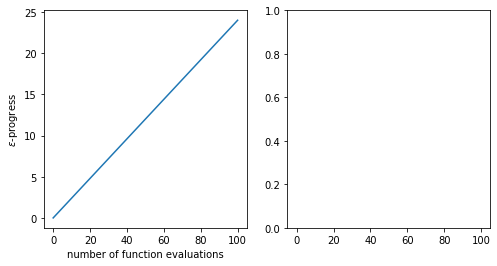

In [5]:
#plotting convergence metrics: epsilon progress and HyperVolume
#for HyperVolume, need to define expected range for each outcome
#haven't figured out yet how to do this only for outcomes of interest 

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(convergence.nfe, convergence.hypervolume)
#ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
#ax2.set_xlabel('number of function evaluations')
plt.show()

In [6]:
results.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,0,0,0,0,0,1,1,...,3,9,4,6,10,3.224424e+06,6.606628e+08,4.080000e+08,139.108484,0.001072
1,0,1,1,0,1,0,0,1,0,0,...,2,2,5,2,10,0.000000e+00,4.966587e+08,4.177000e+08,0.000000,0.000000
2,1,1,0,0,0,0,1,0,0,0,...,6,3,1,7,5,1.074179e+07,7.208368e+08,3.211000e+08,0.000000,0.012090
3,0,1,1,1,0,1,0,1,1,1,...,1,3,8,2,4,6.104983e+06,4.947168e+08,1.164700e+09,0.000000,0.007041
4,0,0,0,1,1,0,1,1,0,0,...,1,1,4,6,3,1.407920e+07,3.851657e+08,7.531000e+08,930.552718,0.001981


### Results sorted to show Dike Heightening at Dike Ring 4

In [7]:
#results for scenario Dike_0 at Dike Ring 4
outcomes_dike = results.loc[:, ['A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2',
                                'EWS_DaysToThreat','Expected Annual Damage','Dike Investment Costs',
                                'Evacuation Costs','Expected Number of Deaths']]

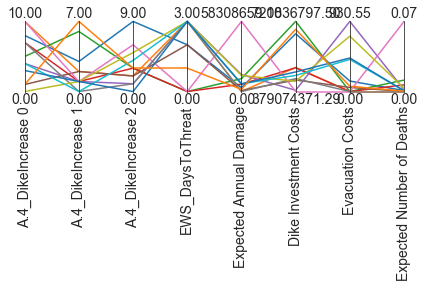

In [8]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes_dike)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_dike)

In [9]:
outcomes_dike.head()

,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,EWS_DaysToThreat,Expected Annual Damage,Dike Investment Costs,Evacuation Costs,Expected Number of Deaths
0,8,3,9,2,3.224424e+06,6.606628e+08,139.108484,0.001072
1,10,2,2,3,0.000000e+00,4.966587e+08,0.000000,0.000000
2,5,6,3,0,1.074179e+07,7.208368e+08,0.000000,0.012090
3,7,1,3,0,6.104983e+06,4.947168e+08,0.000000,0.007041
4,4,1,1,3,1.407920e+07,3.851657e+08,930.552718,0.001981


### Results sorted to show RfR at Dike Ring 4

In [10]:
#results for scenario RFR_0 at Dike Ring 4
outcomes_RfR = results.loc[:, ['4_RfR 0','4_RfR 1', '4_RfR 2','Expected Annual Damage', 'RfR Investment Costs', 
                               'EWS_DaysToThreat','Evacuation Costs','Expected Number of Deaths']]

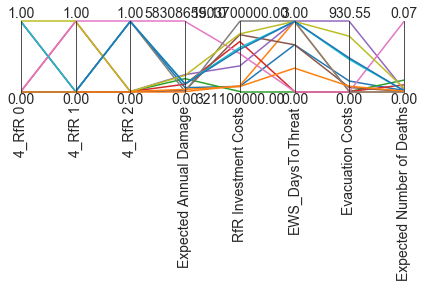

In [11]:
limits = parcoords.get_limits(outcomes_RfR)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_RfR)

In [12]:
outcomes_RfR.head()

,4_RfR 0,4_RfR 1,4_RfR 2,Expected Annual Damage,RfR Investment Costs,EWS_DaysToThreat,Evacuation Costs,Expected Number of Deaths
0,0,0,1,3.224424e+06,4.080000e+08,2,139.108484,0.001072
1,0,0,0,0.000000e+00,4.177000e+08,3,0.000000,0.000000
2,0,0,0,1.074179e+07,3.211000e+08,0,0.000000,0.012090
3,0,1,0,6.104983e+06,1.164700e+09,0,0.000000,0.007041
4,1,0,0,1.407920e+07,7.531000e+08,3,930.552718,0.001981
